### 주제 : 서울시 아파트 매매 실거래가 분석
- 자료출처 : 국토교통부 실거래가 공개시스템
- 시간범위 : 2024-09-18 ~ 2025-09-17 (1년)
- 공간범위 : 서울특별시
- 분석내용 : 건축년도와 거래금액 간 상관관계, 향후 가격 예측

In [1]:
!pip install pandas scikit-learn seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression

# 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'   # mac이면 AppleGothic
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 파일 경로 수정
excel_path = Path("아파트(매매)_실거래가_20250917085457.xlsx")
assert excel_path.exists(), f"파일이 없습니다: {excel_path}"

# 상단 공지문 때문에 header=None으로 먼저 읽고 실제 헤더 행 찾기
tmp = pd.read_excel(excel_path, sheet_name=0, header=None)
header_keys = ['시군구','법정동','아파트','전용면적','거래금액','층','건축년도','계약년월','계약일']
header_row_idx = None
for i in range(min(200, len(tmp))):
    row = tmp.iloc[i].astype(str).tolist()
    hits = sum(any(k in cell for cell in row if isinstance(cell, str)) for k in header_keys)
    if hits >= 2:
        header_row_idx = i
        break
if header_row_idx is None:
    header_row_idx = 0
    print("⚠️ 헤더 자동 탐지 실패 → 0행 사용")

df = pd.read_excel(excel_path, sheet_name=0, header=header_row_idx)
print("헤더 행:", header_row_idx, "| 형태:", df.shape)
df.head()

헤더 행: 0 | 형태: (68368, 21)


,NO,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),...,층,매수자,매도자,건축년도,도로명,해제사유발생일,거래유형,중개사소재지,등기일자,주택유형
0,1,서울특별시 강북구 미아동,1354,1354,0,벽산라이브파크,59.670,202509,16,"52,500",...,9,개인,개인,2004,솔샘로 159,-,중개거래,서울 성북구,-,아파트
1,2,서울특별시 성북구 하월곡동,90-700,90,700,베로니스,52.900,202509,16,"59,000",...,13,개인,개인,2020,화랑로1길 7,-,중개거래,서울 성북구,-,아파트
2,3,서울특별시 강서구 등촌동,662-3,662,3,신송타워,84.960,202509,16,"59,900",...,15,개인,개인,1997,화곡로63길 93,-,중개거래,서울 강서구,-,아파트
3,4,서울특별시 도봉구 창동,827,827,0,동도센트리움,80.822,202509,16,"67,000",...,6,개인,개인,2009,마들로 579-19,-,중개거래,서울 도봉구,-,아파트
4,5,서울특별시 노원구 상계동,670,670,0,상계주공9(고층),49.940,202509,16,"48,500",...,3,개인,개인,1988,노원로 532,-,중개거래,서울 노원구,-,아파트


In [4]:
dfc = df.copy()
dfc.columns = [str(c).strip() for c in dfc.columns]

# 거래금액(만원) 숫자화
price_col = next((c for c in ['거래금액(만원)','거래금액','거래금액 (만원)'] if c in dfc.columns), None)
assert price_col, "가격 컬럼을 찾지 못했습니다."
price = dfc[price_col].astype(str).str.replace(',', '', regex=False).str.strip().replace({'': np.nan})
price = pd.to_numeric(price, errors='coerce')
if price_col != '거래금액(만원)' and price.dropna().median() > 100000:
    price = price / 10000.0
dfc['price_만원'] = price

# 건축년도 숫자화
if '건축년도' in dfc.columns:
    dfc['건축년도'] = pd.to_numeric(dfc['건축년도'], errors='coerce')

# 거래일/연월 파생
if {'계약년월','계약일'}.issubset(dfc.columns):
    day = dfc['계약일'].astype('Int64').astype(str).str.zfill(2)
    dfc['거래일'] = pd.to_datetime(dfc['계약년월'].astype(str) + day, format='%Y%m%d', errors='coerce')
else:
    if '계약년월' in dfc.columns:
        dfc['거래일'] = pd.to_datetime(dfc['계약년월'].astype(str)+'01', format='%Y%m%d', errors='coerce')
    else:
        dfc['거래일'] = pd.NaT
dfc['거래연월'] = dfc['거래일'].dt.to_period('M').dt.to_timestamp()

dfc[['건축년도','price_만원','거래연월']].head()

,건축년도,price_만원,거래연월
0,2004,52500,2025-09-01
1,2020,59000,2025-09-01
2,1997,59900,2025-09-01
3,2009,67000,2025-09-01
4,1988,48500,2025-09-01


피어슨 상관계수(건축년도 vs 가격): 0.0099
스피어만 상관계수(건축년도 vs 가격): 0.1381


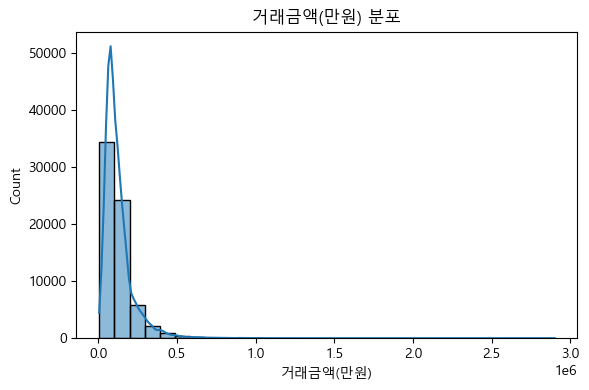

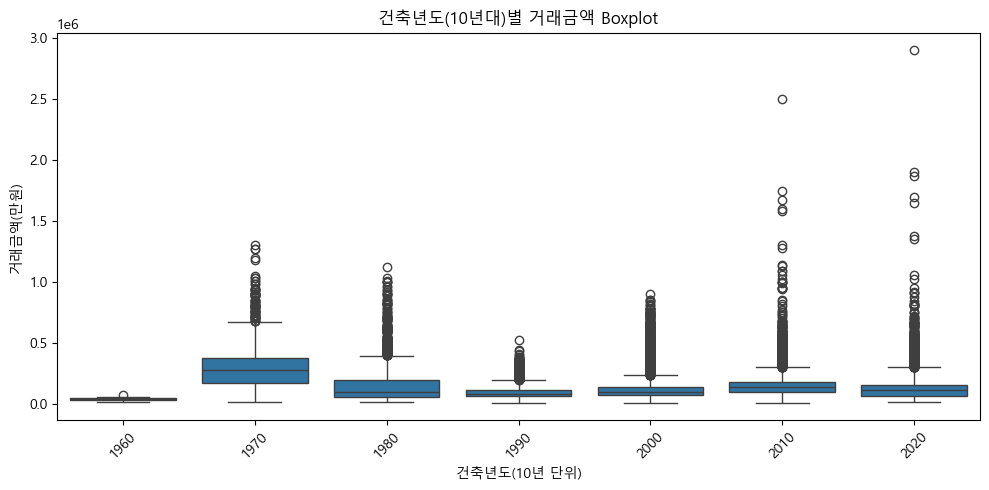

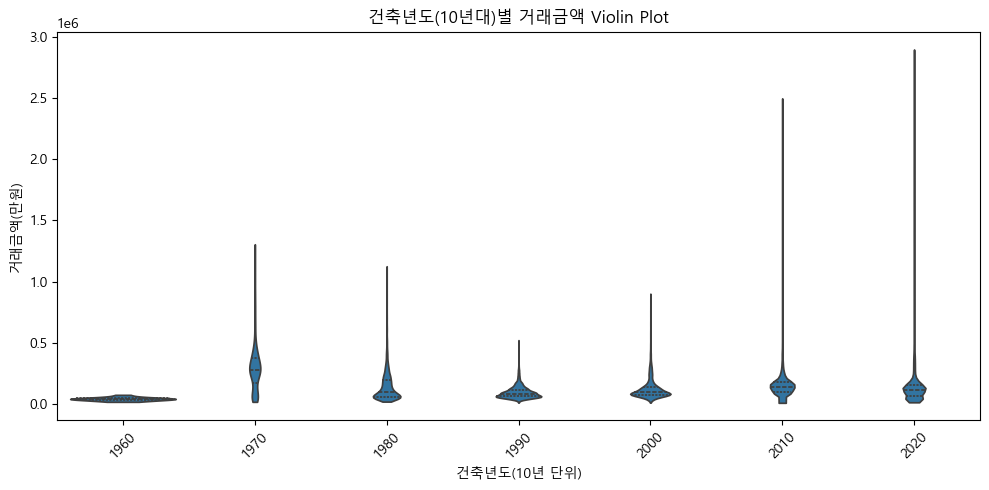

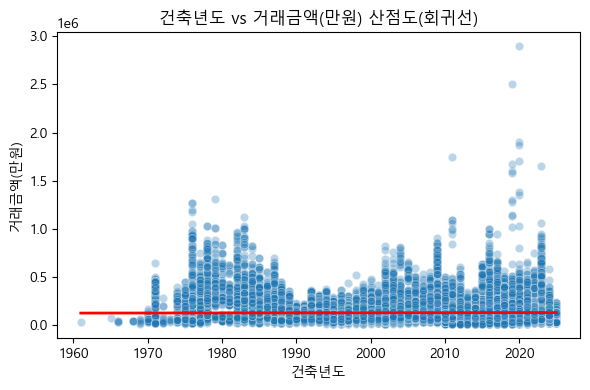

단순회귀 기울기(연식 1년↑시 금액 변화량, 만원): 84.77


In [9]:
# 결측 제거
plot_df = dfc[['건축년도','price_만원']].dropna()

# 상관계수
pearson = plot_df.corr(method='pearson').iloc[0,1]
spearman = plot_df.corr(method='spearman').iloc[0,1]
print(f"피어슨 상관계수(건축년도 vs 가격): {pearson:.4f}")
print(f"스피어만 상관계수(건축년도 vs 가격): {spearman:.4f}")

# === 1) 거래금액 히스토그램 ===
plt.figure(figsize=(6,4))
sns.histplot(plot_df['price_만원'], kde=True, bins=30)
plt.xlabel('거래금액(만원)')
plt.title('거래금액(만원) 분포')
plt.tight_layout()
plt.show()

# === 2) 건축년도별 거래금액 상자그림(Boxplot) ===
plot_df['건축년도_구간'] = (plot_df['건축년도']//10)*10  # 10년 단위 구간화
plt.figure(figsize=(10,5))
sns.boxplot(x='건축년도_구간', y='price_만원', data=plot_df)
plt.xlabel('건축년도(10년 단위)')
plt.ylabel('거래금액(만원)')
plt.title('건축년도(10년대)별 거래금액 Boxplot')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 3) 건축년도별 거래금액 바이올린 Plot ===
plt.figure(figsize=(10,5))
sns.violinplot(x='건축년도_구간', y='price_만원', data=plot_df, inner='quartile', cut=0)
plt.xlabel('건축년도(10년 단위)')
plt.ylabel('거래금액(만원)')
plt.title('건축년도(10년대)별 거래금액 Violin Plot')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 4) 산점도 + 단순 회귀선 ===
plt.figure(figsize=(6,4))
sns.scatterplot(x='건축년도', y='price_만원', data=plot_df, alpha=0.3)
X_lin = plot_df['건축년도'].to_numpy().reshape(-1,1)
y_lin = plot_df['price_만원'].to_numpy()
lr = LinearRegression().fit(X_lin, y_lin)
x_line = np.linspace(np.nanmin(X_lin), np.nanmax(X_lin), 100).reshape(-1,1)
y_line = lr.predict(x_line)
plt.plot(x_line, y_line, color='red', linewidth=2)
plt.xlabel('건축년도')
plt.ylabel('거래금액(만원)')
plt.title('건축년도 vs 거래금액(만원) 산점도(회귀선)')
plt.tight_layout()
plt.show()

print(f"단순회귀 기울기(연식 1년↑시 금액 변화량, 만원): {lr.coef_[0]:.2f}")

월별 평균 가격(상위 5건):
        거래연월       price_만원
0 2024-09-01  125273.413043
1 2024-10-01  121784.969697
2 2024-11-01  123747.227389
3 2024-12-01  119218.092780
4 2025-01-01  127348.355783


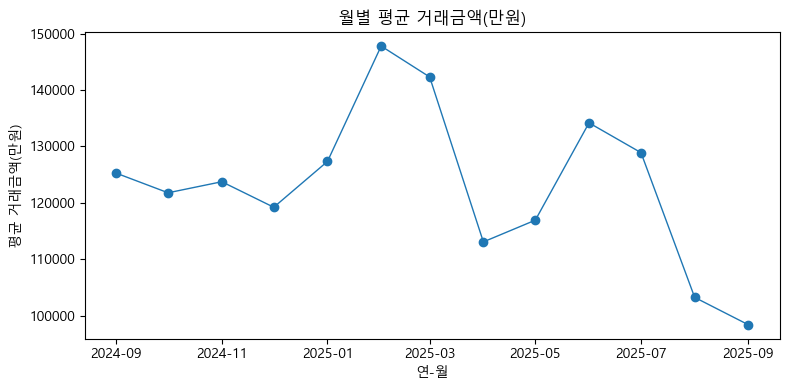

추세선 기울기(월당 변화량, 만원): -1342.53
현재 판단된 추세: 하락 추세

향후 6개월 예측:
        예측연월  예측_평균거래금액(만원)
0 2025-10-01  113848.813808
1 2025-11-01  112506.280480
2 2025-12-01  111163.747153
3 2026-01-01  109821.213825
4 2026-02-01  108478.680497
5 2026-03-01  107136.147170


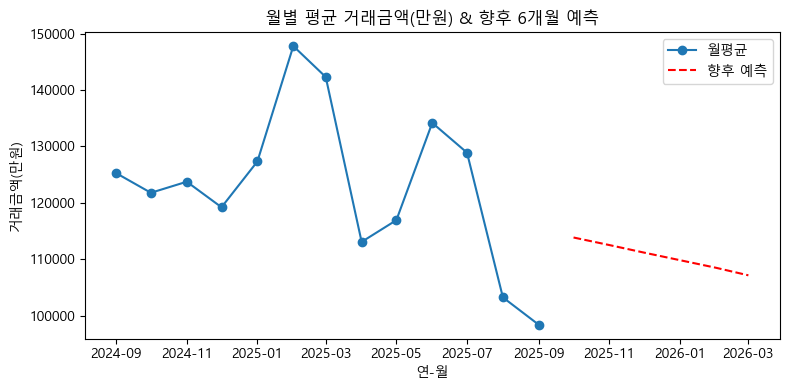

In [6]:
# 월별 평균 가격 집계
ts = (
    dfc.dropna(subset=['거래연월','price_만원'])
       .groupby('거래연월', as_index=False)['price_만원'].mean()
       .sort_values('거래연월')
)
print("월별 평균 가격(상위 5건):")
print(ts.head())

# 시계열 시각화
plt.figure(figsize=(8,4))
plt.plot(ts['거래연월'], ts['price_만원'], marker='o', linewidth=1)
plt.title('월별 평균 거래금액(만원)')
plt.xlabel('연-월')
plt.ylabel('평균 거래금액(만원)')
plt.tight_layout()
plt.show()

# 단순 추세선(LinearRegression on time index)
ts = ts.reset_index(drop=True).copy()
ts['t'] = np.arange(len(ts))
X_t = ts[['t']].values
y_t = ts['price_만원'].values
lin = LinearRegression().fit(X_t, y_t)
slope = lin.coef_[0]
print(f"추세선 기울기(월당 변화량, 만원): {slope:.2f}")
trend = "상승 추세" if slope > 0 else ("하락 추세" if slope < 0 else "횡보")
print("현재 판단된 추세:", trend)

# 다음 6개월 예측
h = 6
future_t = np.arange(len(ts), len(ts)+h).reshape(-1,1)
future_pred = lin.predict(future_t)
last_month = ts['거래연월'].iloc[-1]
future_months = pd.date_range(last_month, periods=h+1, freq='MS')[1:]
forecast = pd.DataFrame({'예측연월': future_months,
                         '예측_평균거래금액(만원)': future_pred})
print("\n향후 6개월 예측:")
print(forecast)

# 예측 시각화
plt.figure(figsize=(8,4))
plt.plot(ts['거래연월'], ts['price_만원'], marker='o', label='월평균')
plt.plot(future_months, future_pred, 'r--', label='향후 예측')
plt.title('월별 평균 거래금액(만원) & 향후 6개월 예측')
plt.xlabel('연-월')
plt.ylabel('거래금액(만원)')
plt.legend()
plt.tight_layout()
plt.show()

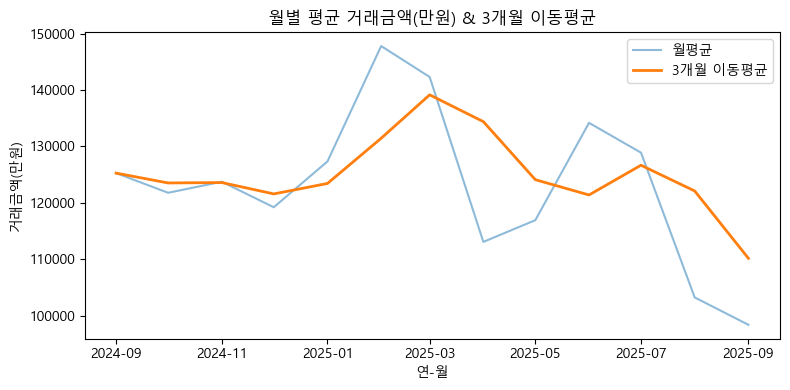

In [7]:
ts['ma3'] = ts['price_만원'].rolling(3, min_periods=1).mean()
plt.figure(figsize=(8,4))
plt.plot(ts['거래연월'], ts['price_만원'], alpha=0.5, label='월평균')
plt.plot(ts['거래연월'], ts['ma3'], linewidth=2, label='3개월 이동평균')
plt.title('월별 평균 거래금액(만원) & 3개월 이동평균')
plt.xlabel('연-월')
plt.ylabel('거래금액(만원)')
plt.legend()
plt.tight_layout()
plt.show()

거래금액(만원)과 다른 변수의 상관계수:
price_만원    1.000000
전용면적(㎡)     0.584424
층           0.161170
NO          0.035065
계약년월        0.022225
건축년도        0.009880
부번         -0.002290
계약일        -0.004475
본번         -0.047397
Name: price_만원, dtype: float64


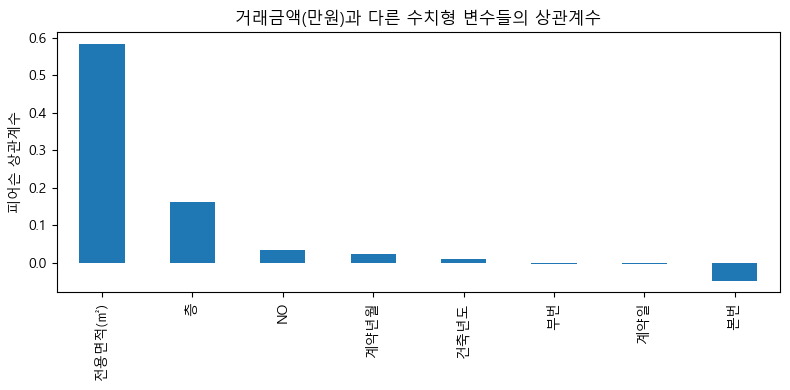

In [8]:
# 1) 수치형 변수만 추출
num_df = dfc.select_dtypes(include=[np.number])

# 2) 거래금액(만원)과의 상관계수 계산 (피어슨)
corr_with_price = num_df.corr(method='pearson')['price_만원'].sort_values(ascending=False)

print("거래금액(만원)과 다른 변수의 상관계수:")
print(corr_with_price)

# 3) 시각화 (막대그래프)
corr_with_price.drop('price_만원').plot(kind='bar', figsize=(8,4))
plt.title('거래금액(만원)과 다른 수치형 변수들의 상관계수')
plt.ylabel('피어슨 상관계수')
plt.tight_layout()
plt.show()